TODO: 
* modify pipeline, more options
* test data as whole, not couple of chunks
* visualisation for diagnosing


Architectures:
* conv2d
* cnn + lstm: https://stats.stackexchange.com/questions/252095/sequence-classification-via-neural-networks

In [1]:
from IPython.core.debugger import set_trace

import numpy as np
from numpy.random import seed
seed(1)
#display all values from array
np.set_printoptions(threshold=np.nan)
#display not in scientific format
np.set_printoptions(suppress=True)

# from tensorflow import set_random_seed
# set_random_seed(2)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, BatchNormalization, Activation
from keras.optimizers import RMSprop, SGD
from keras import callbacks
from keras.constraints import maxnorm

from sklearn.model_selection import train_test_split, StratifiedKFold

CHUNK_SIZE_IN_SECONDS = 4

Using TensorFlow backend.


In [3]:
from time import time
import datetime

def create_current_time():
    timestamp = time()
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [4]:
def callbacks_list(description): 
    return [
#     callbacks.EarlyStopping(
#         monitor='val_acc', 
#         patience=5
#     ),
    callbacks.ModelCheckpoint(
        filepath='tmp/best_model.h5', 
        monitor='val_loss', 
        save_best_only=True
    ),
    callbacks.TensorBoard(
        log_dir='tmp/logs/{}:{}'.format(description, create_current_time()),
        histogram_freq=0, #it has to be 0, otherwise throws error during training
        write_graph=True,
        write_images=True
    )
]

In [5]:
import inspect

def get_function_name():
    return inspect.stack()[1][3]

In [6]:
from data_reader import get_data

def load_data_kfold(folds_number):
    x, y = get_data(CHUNK_SIZE_IN_SECONDS)
    
    x_train, x_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=0.05)
    
    folds = list(StratifiedKFold(n_splits=folds_number, 
                                 shuffle=True, 
                                 random_state=1).split(x_train, y_train))
    
    return folds, x_train, y_train, x_test, y_test

In [7]:
# ~70-80% test, overfitting
def conv_1D_62_32(input_shape):
    description = get_function_name()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description

#less overfitting
def conv_1D_smaller_32_16(input_shape):
    description = get_function_name()
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description


def testing(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=16, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description


def baseline(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Dense(60, kernel_initializer='normal', activation='relu', input_shape=input_shape))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model, description

In [8]:
def run_pipeline(create_model, folds, epochs, learning_rate):
    score = []
    best_model_score = []
    
    for fold_number, (train_idx, val_idx) in enumerate(folds):
        print('\nFold: ', fold_number + 1)
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv = y_train[val_idx]
                
        input_shape = x_train.shape[1:]

        model, model_description = create_model(input_shape)
        
        description = "lr = {}".format(learning_rate)

        callbacks = callbacks_list("{}. {}-{}".format(model_description, 
                                                      description, 
                                                      fold_number))

        model.compile(optimizer=RMSprop(lr=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['acc'])

        history = model.fit(x_train_cv,
                            y_train_cv,
                            epochs=epochs,
                            batch_size=16,
                            callbacks=callbacks,
                            validation_data=(x_valid_cv, y_valid_cv),
                            verbose=0)

        score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))

        model.load_weights("tmp/best_model.h5")
        best_model_score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))
        
        print("--Last epoch validation accuracy: %.2f%%" % (score[fold_number][1]*100))
        print("--Best model validation accuracy: %.2f%%" % (best_model_score[fold_number][1]*100))
        
    return score, best_model_score

In [9]:
folds, x_train, y_train, x_test, y_test = load_data_kfold(folds_number=10)

In [10]:
score, best_model_score = run_pipeline(create_model=conv_1D_smaller_32_16,
                                       folds=folds,
                                       epochs=100,
                                       learning_rate=3e-5)

avg_accuracy = np.mean([row[1] for row in best_model_score])
print("Average best models validation accuracy: {}".format(avg_accuracy))


Fold:  1
--Last epoch validation accuracy: 74.11%
--Best model validation accuracy: 75.89%

Fold:  2
--Last epoch validation accuracy: 75.00%
--Best model validation accuracy: 75.89%

Fold:  3
--Last epoch validation accuracy: 67.86%
--Best model validation accuracy: 59.82%

Fold:  4
--Last epoch validation accuracy: 74.11%
--Best model validation accuracy: 74.11%

Fold:  5
--Last epoch validation accuracy: 80.36%
--Best model validation accuracy: 75.89%

Fold:  6
--Last epoch validation accuracy: 71.43%
--Best model validation accuracy: 73.21%

Fold:  7
--Last epoch validation accuracy: 76.79%
--Best model validation accuracy: 79.46%

Fold:  8
--Last epoch validation accuracy: 75.00%
--Best model validation accuracy: 75.89%

Fold:  9
--Last epoch validation accuracy: 63.06%
--Best model validation accuracy: 63.96%

Fold:  10
--Last epoch validation accuracy: 77.27%
--Best model validation accuracy: 78.18%
Average best models validation accuracy: 0.732324353897517


In [12]:
def plot_results(history):
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
# plot_results(history)
# using view in tensorboard instead

In [16]:
from plots_printer import draw_plots, draw_plots_with_chunks
from data_reader import load_input_data, prepare_chunks

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

FREQUENCY_TO_SAMPLING_RATIO = 100

input_data, target, headers = load_input_data()
chunks_input, chunks_target = prepare_chunks(input_data, 
                                            target, 
                                            chunk_size_in_seconds=CHUNK_SIZE_IN_SECONDS, 
                                            ratio=FREQUENCY_TO_SAMPLING_RATIO)

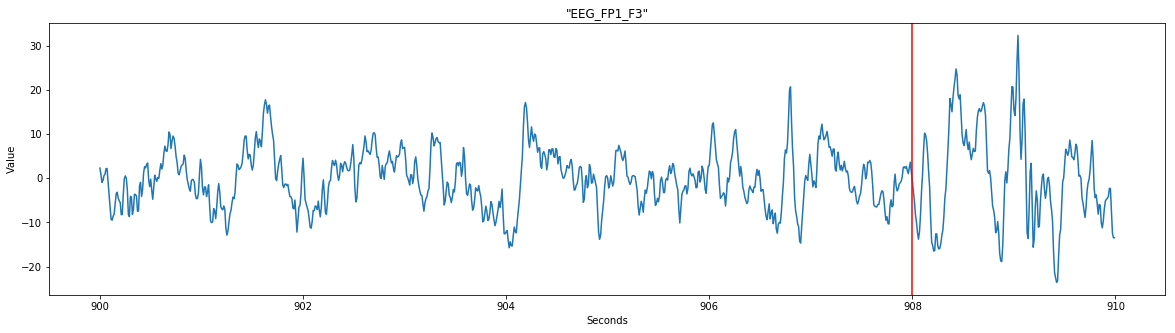

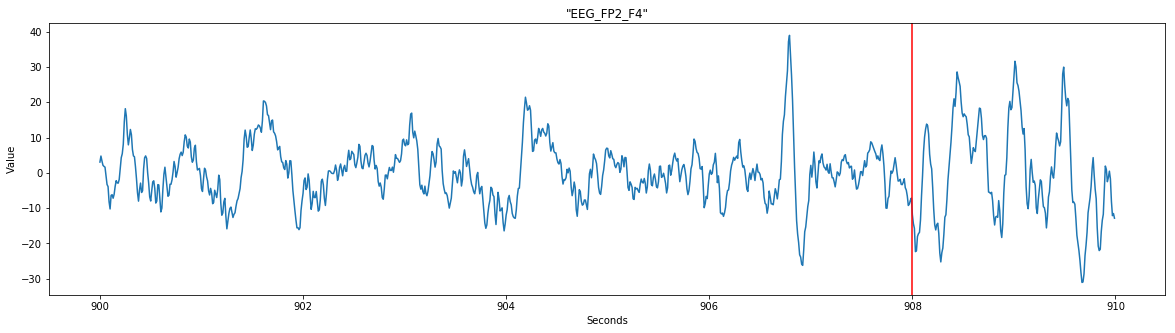

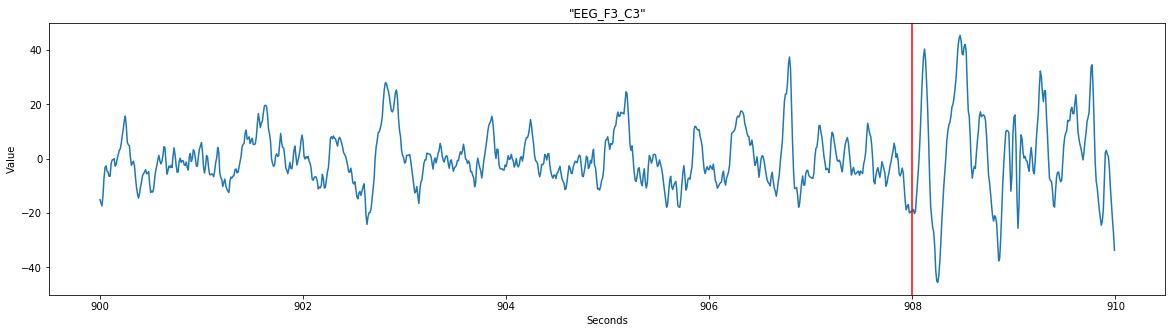

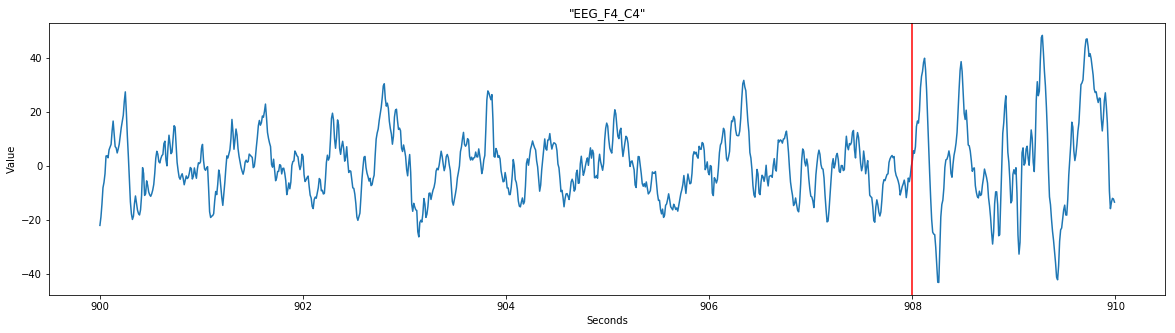

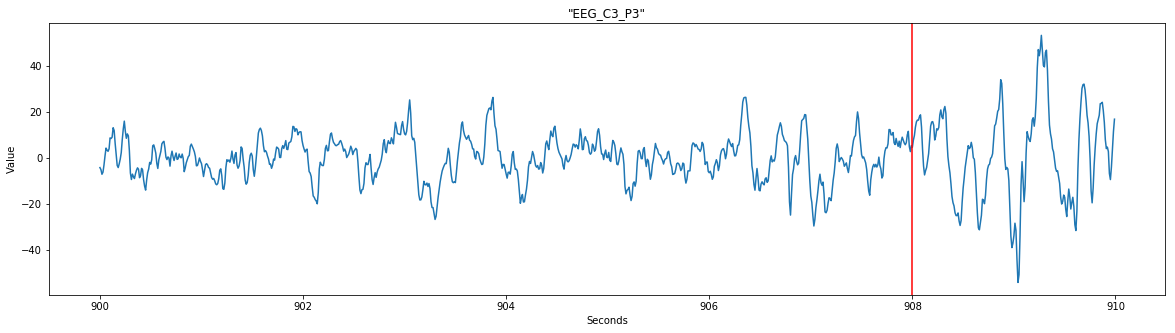

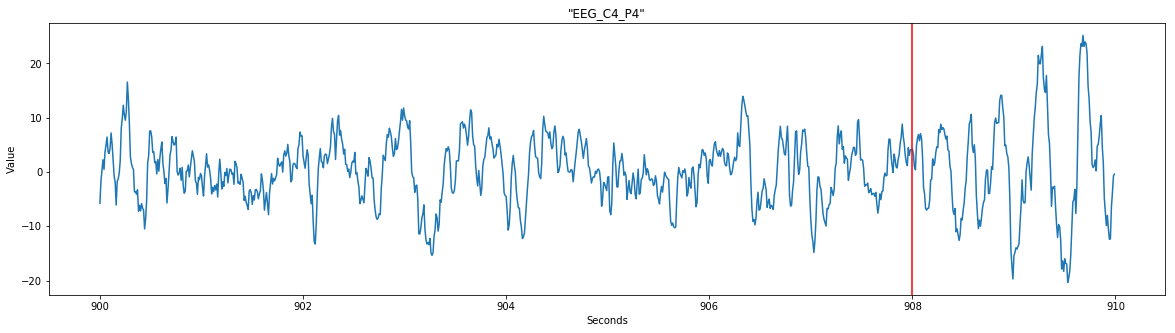

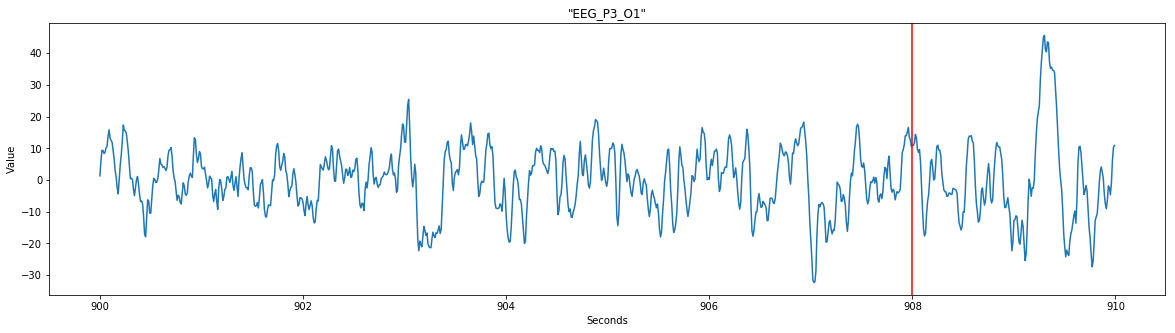

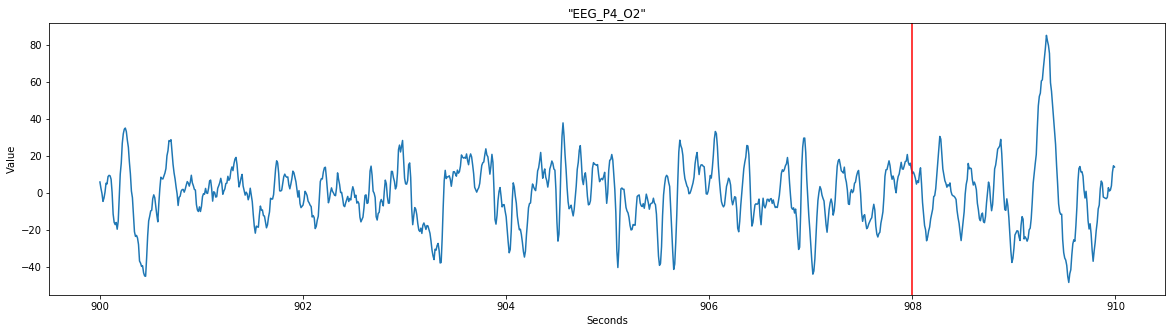

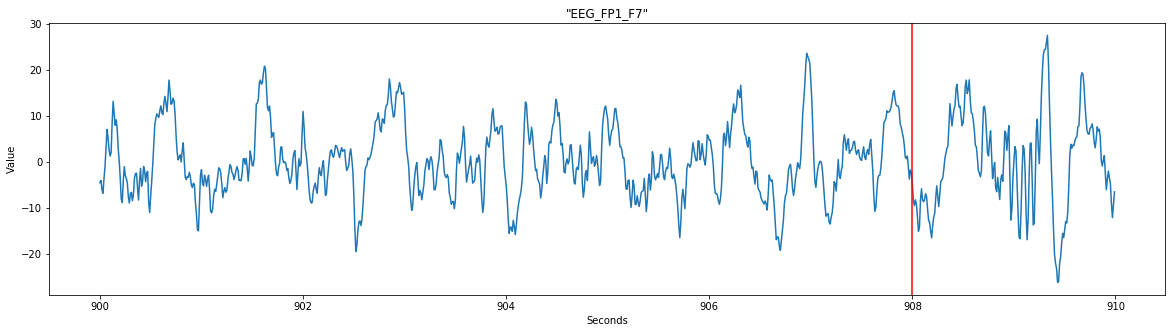

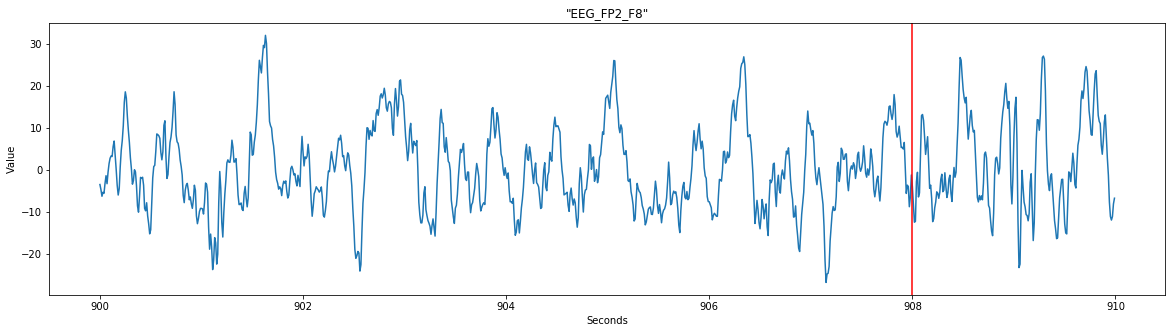

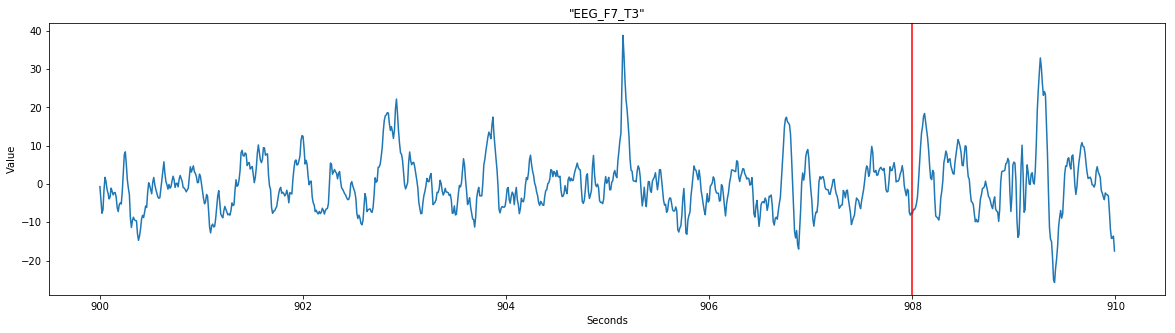

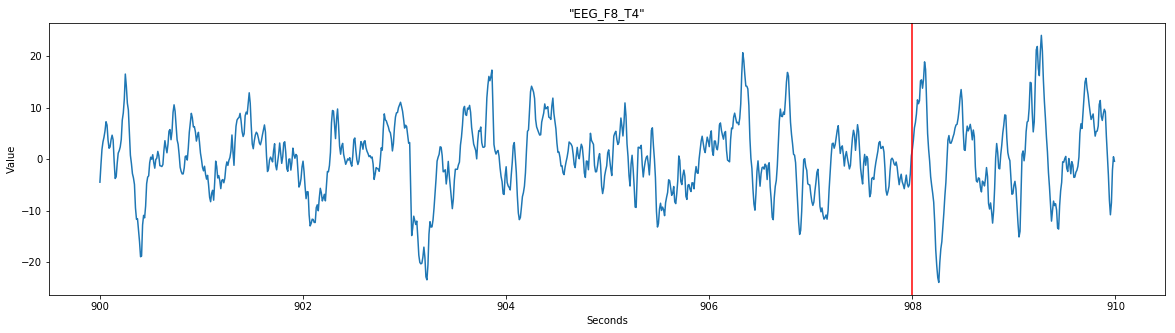

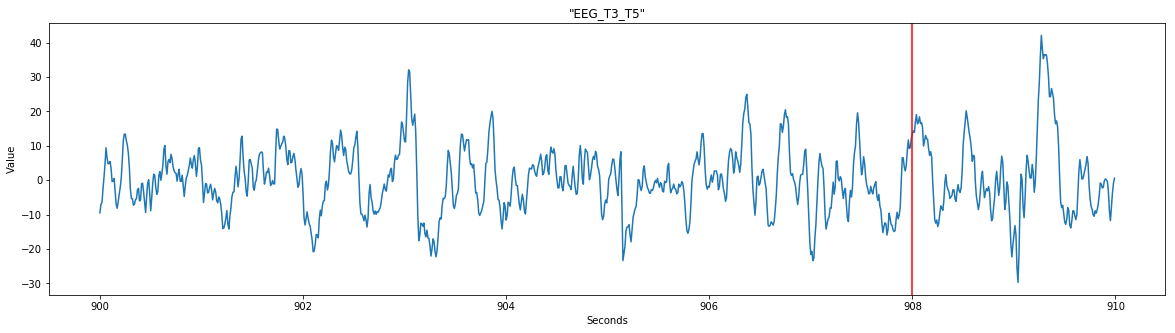

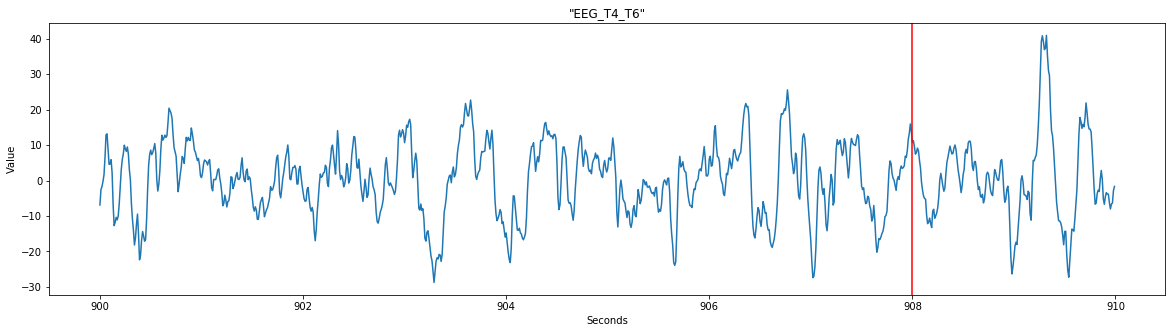

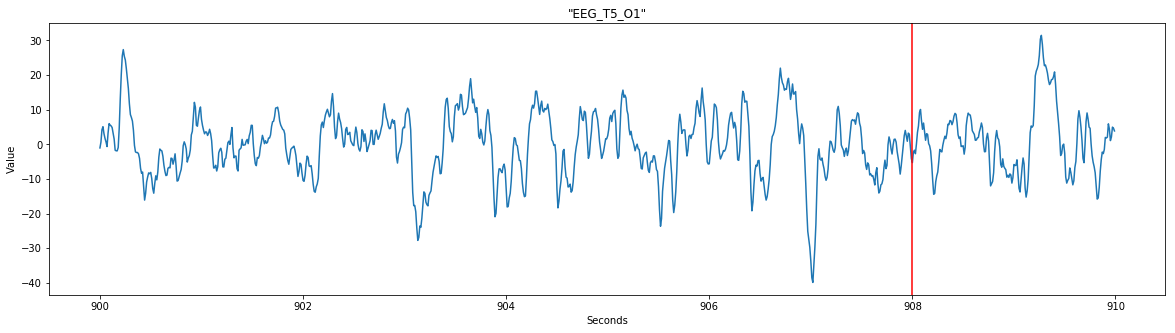

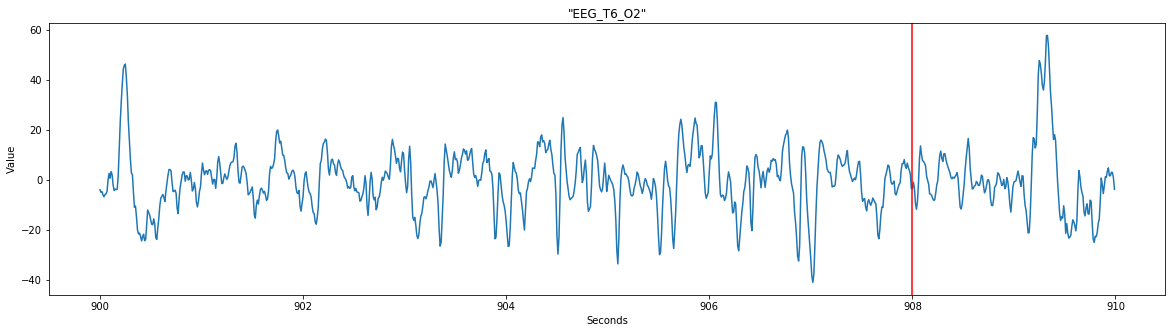

In [17]:
draw_plots(input_data, 
           target, 
           headers, 
           patient=0, 
           start_second=900, 
           end_second=910,
           ratio=FREQUENCY_TO_SAMPLING_RATIO)

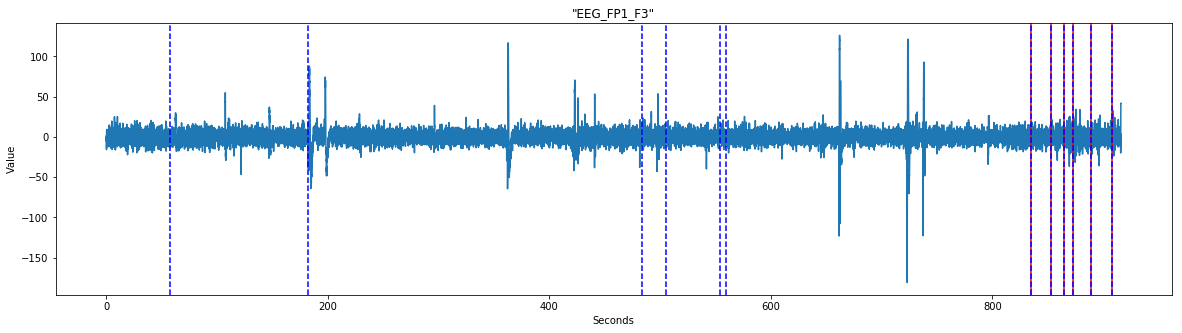

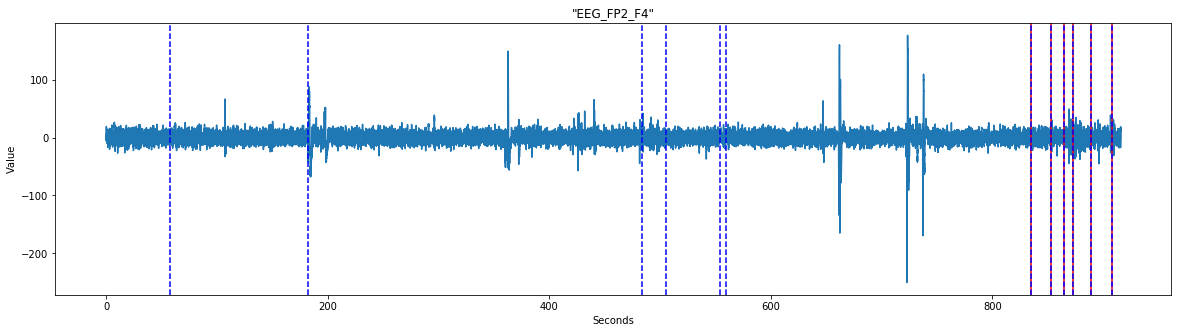

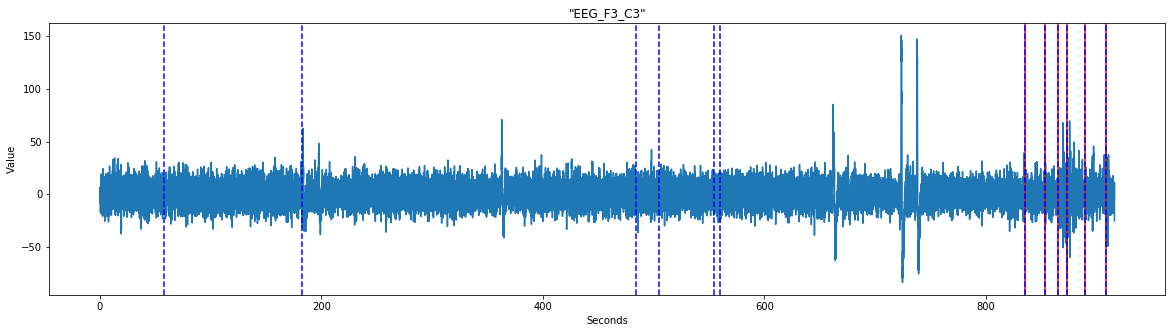

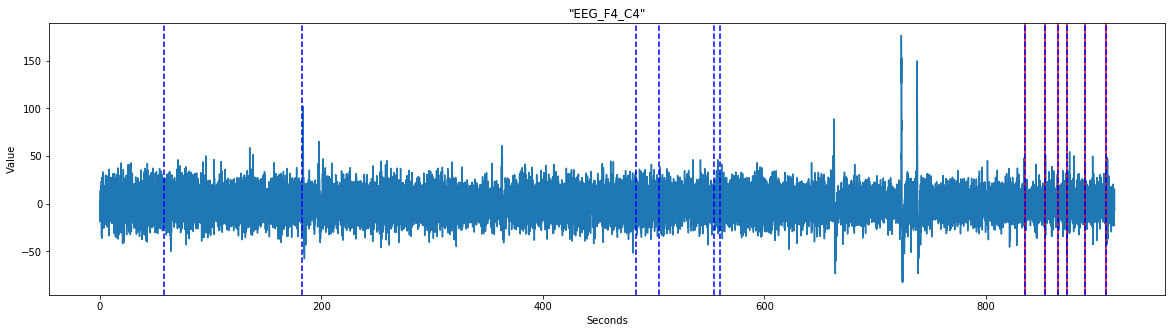

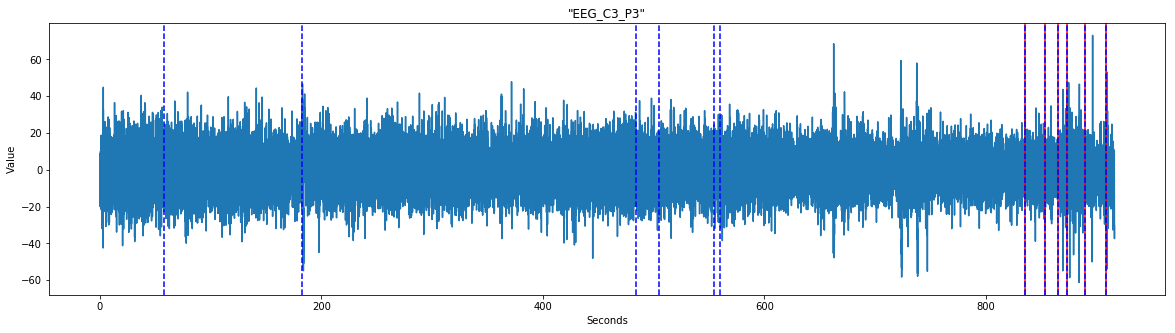

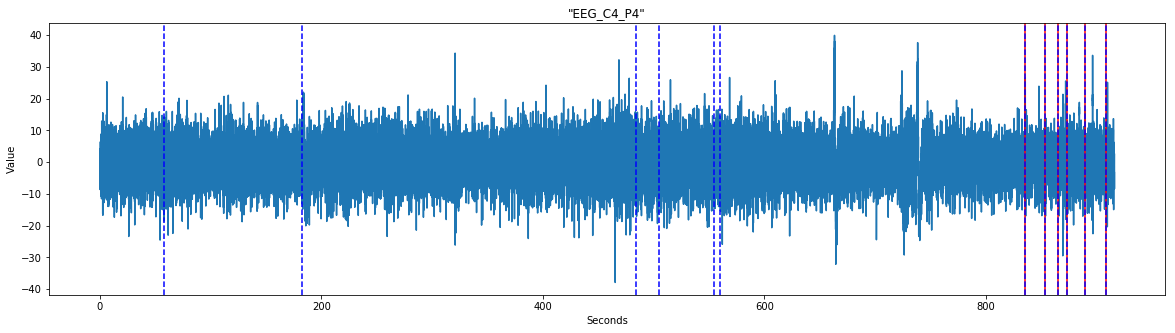

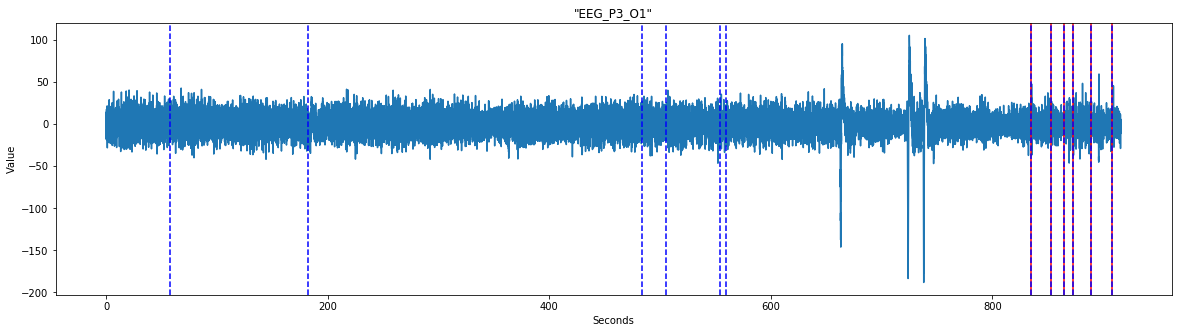

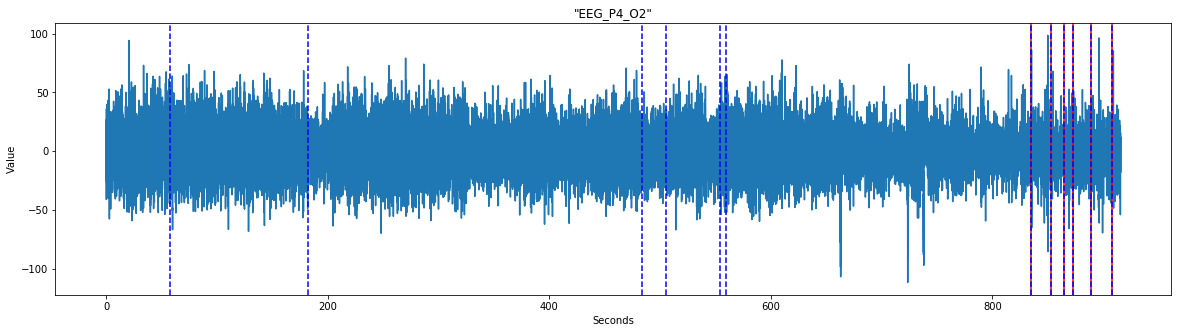

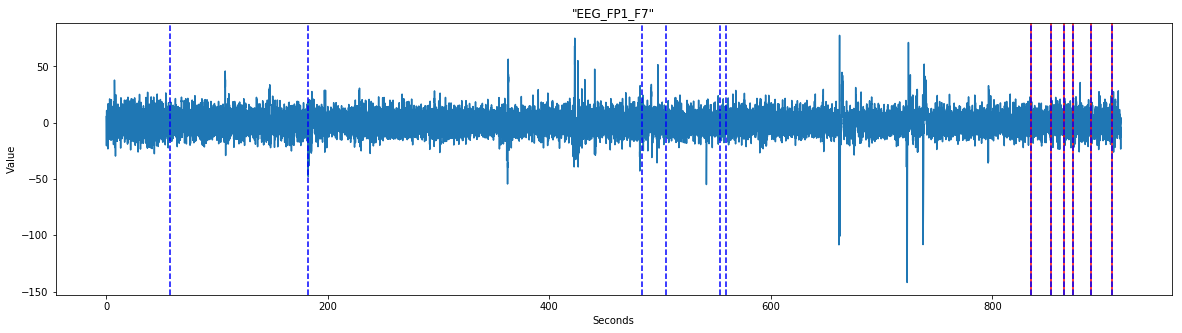

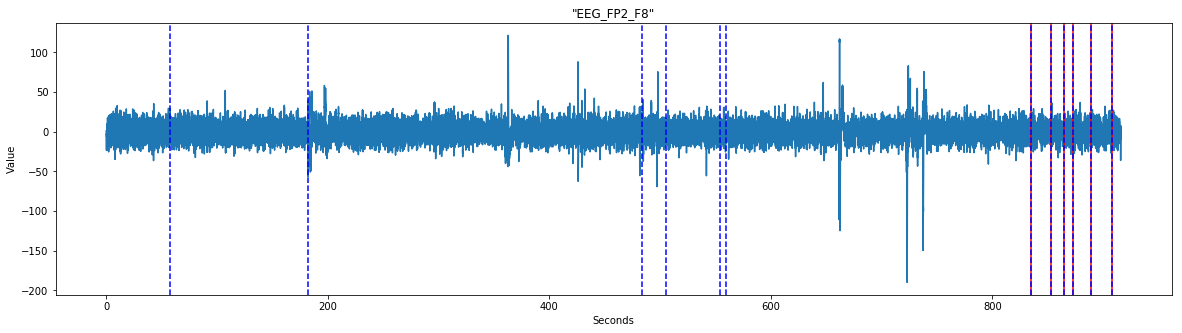

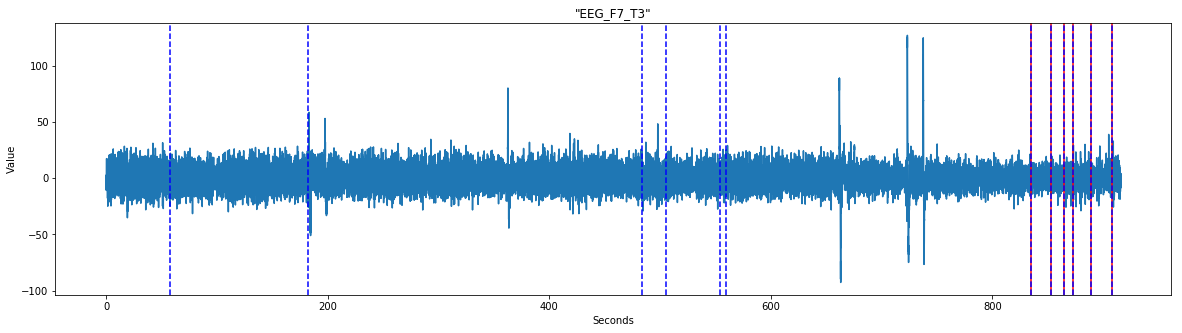

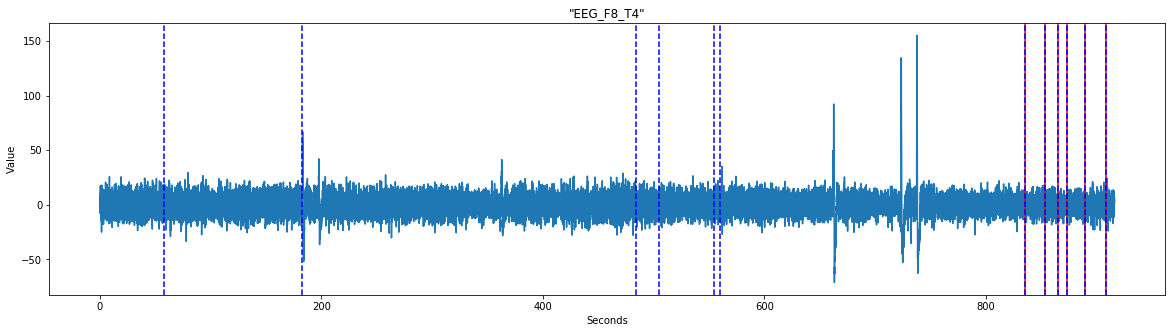

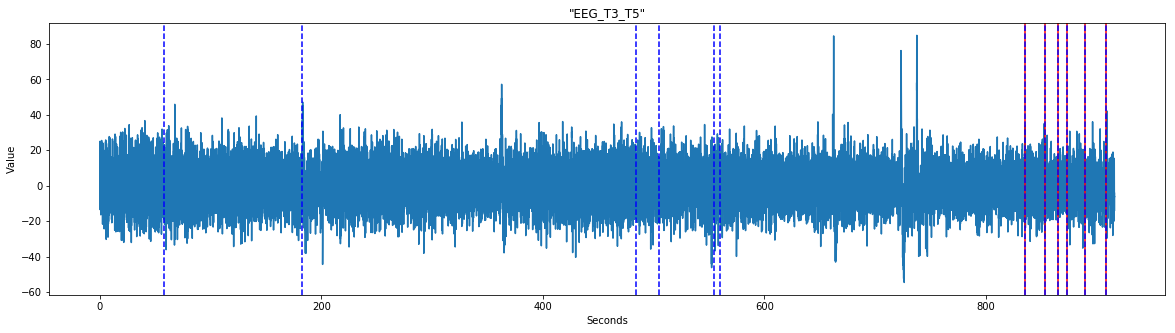

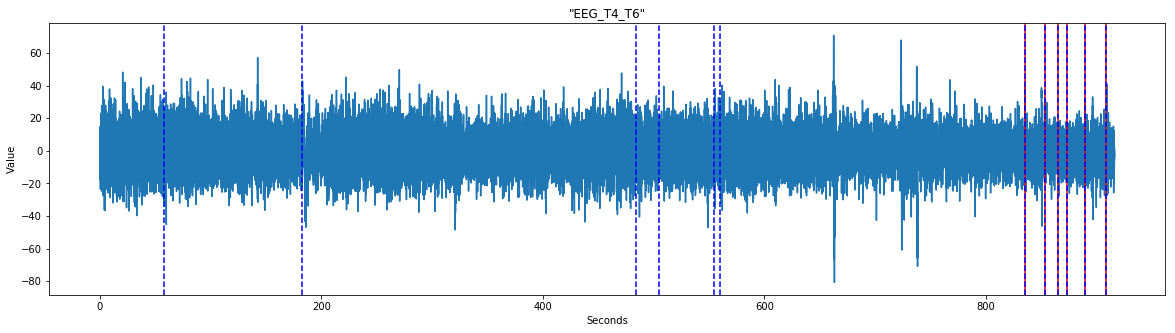

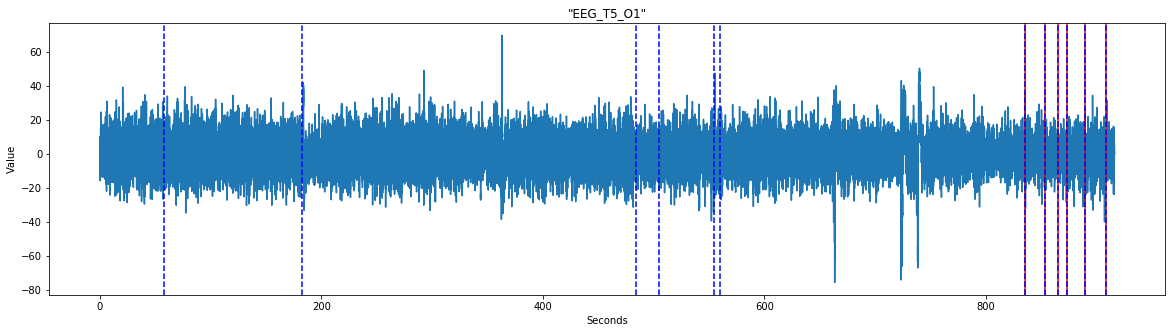

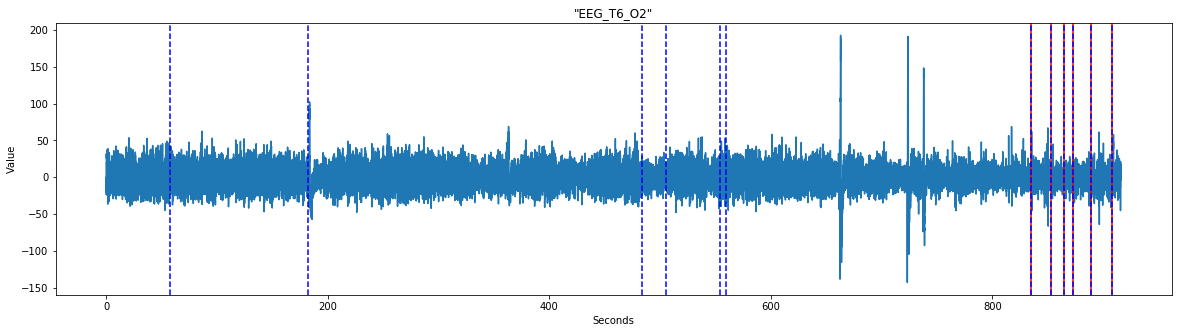

In [18]:
draw_plots_with_chunks(input_data, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)